In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as hc


## Подготовка и изучение данных.

In [2]:
data = pd.read_excel("data/sverstal_data.xlsx")
data.head()

,Номер Z-конфигурации,КлчПост/Потребн,Базовая ЕИ,Количество (Норматив),VID_PROD_GP,TOL,SHIRINA,DLINA,VID_TO,MARKA,ST_PROD
0,401077983,53.526,Т,1197.6,P0,58.0,2440,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
1,401090004,55.476,Т,1197.6,P0,32.2,2260,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
2,401090006,47.301,Т,1197.6,P0,33.0,1880,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
3,401090005,46.477,Т,1197.6,P0,38.0,1609,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
4,401089979,143.408,Т,1197.6,P0,58.0,2450,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Номер Z-конфигурации   1162 non-null   int64  
 1   КлчПост/Потребн        1162 non-null   float64
 2   Базовая ЕИ             1162 non-null   object 
 3   Количество (Норматив)  1162 non-null   float64
 4   VID_PROD_GP            1162 non-null   object 
 5   TOL                    1162 non-null   float64
 6   SHIRINA                1162 non-null   int64  
 7   DLINA                  1162 non-null   int64  
 8   VID_TO                 1162 non-null   object 
 9   MARKA                  1162 non-null   object 
 10  ST_PROD                1162 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 100.0+ KB


In [4]:
data = data.drop(['Базовая ЕИ', 'VID_PROD_GP'], axis =1)

In [5]:
data = data.rename(columns={'Количество (Норматив)': 'target'})

In [6]:
num_col = data.select_dtypes(include='number').columns.to_list()
cat_col = data.select_dtypes(exclude='number').columns.to_list()

In [7]:
cat_col

['VID_TO', 'MARKA', 'ST_PROD']

In [8]:
data.isna().sum()

Номер Z-конфигурации    0
КлчПост/Потребн         0
target                  0
TOL                     0
SHIRINA                 0
DLINA                   0
VID_TO                  0
MARKA                   0
ST_PROD                 0
dtype: int64

In [9]:
data.duplicated().sum()

np.int64(0)

In [10]:
corr_matrix = data[num_col].corr(method='pearson')

<Axes: title={'center': 'Тепловая карта корреляции признаков по методу Пирсона'}>

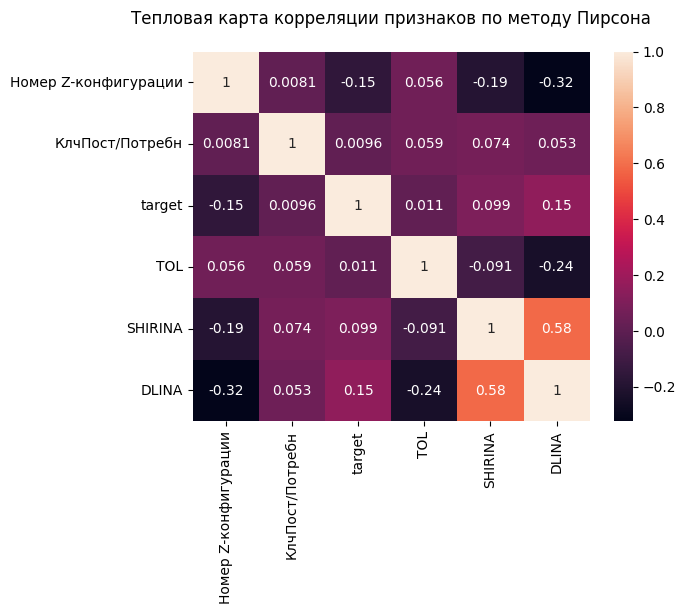

In [11]:
plt.title('Тепловая карта корреляции признаков по методу Пирсона', pad=20)
sns.heatmap(corr_matrix, annot=True)

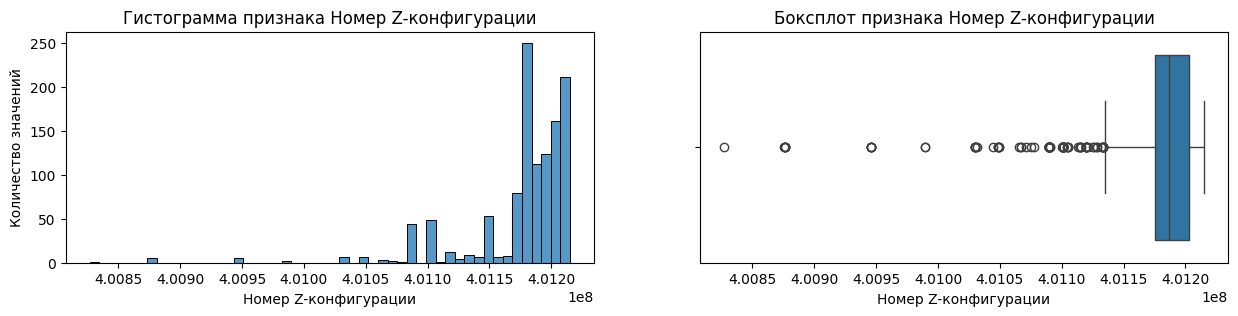

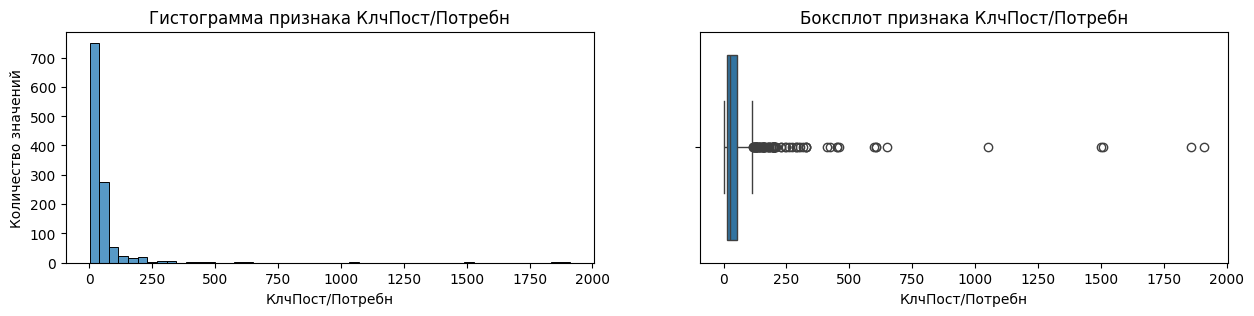

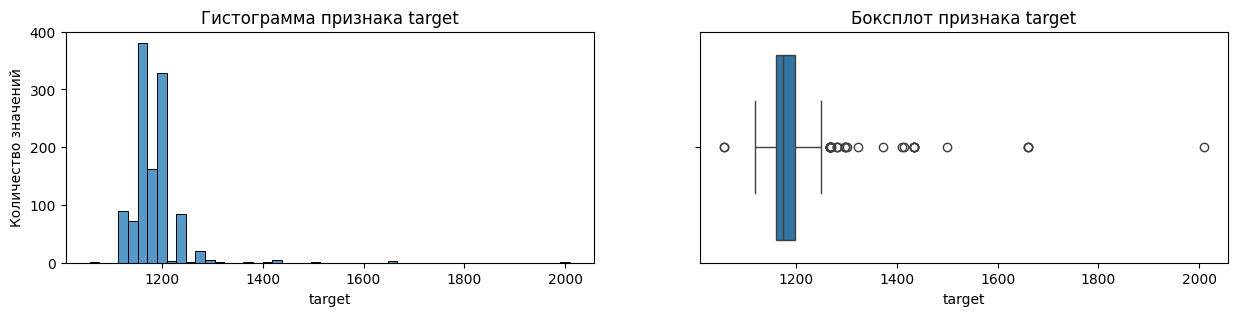

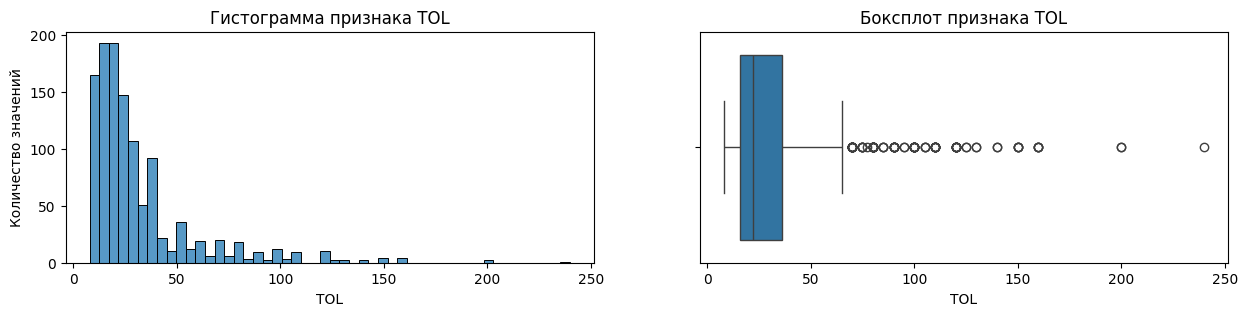

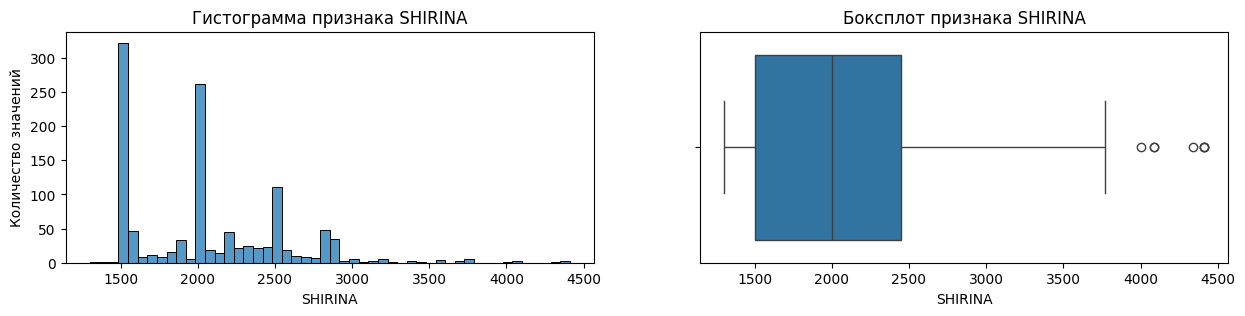

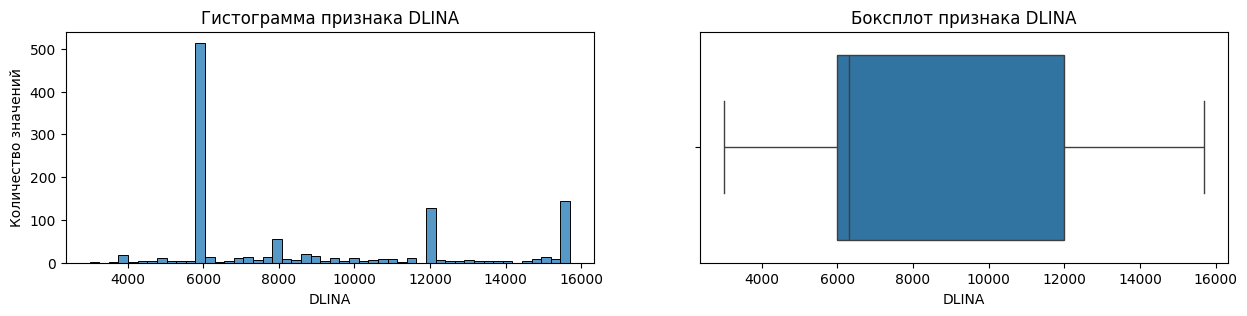

In [12]:
for i in num_col:
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    plt.title ('Гистограмма признака '+i)
    sns.histplot(data=data, x=i, bins=50)
    plt.ylabel('Количество значений')
    plt.subplot(1,2,2)
    plt.title ('Боксплот признака '+i)
    sns.boxplot(data=data, x=i)             

Данные предоставлены с выбросами.

## Подготовка модели

In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline

In [14]:
# Номер Z-конфигурации - ID объектов
num_col = num_col[1:]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_col),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_col)
    ]
)

X = preprocessor.fit_transform(data)
label = data['Номер Z-конфигурации']

In [15]:
# необходимо для метода локтя
def compute_wcss(X, labels):
    if hasattr(X, "todense"):
        X = np.asarray(X.todense())  # если sparse
    wcss = 0
    for cluster in np.unique(labels):
        cluster_points = X[labels == cluster]
        centroid = cluster_points.mean(axis=0)
        wcss += ((cluster_points - centroid) ** 2).sum()
    return wcss

In [16]:
wcss_list = []
silhouette_list = []

# перебираем число кластеров
k_range = range(2, 50) 
for k in k_range:

    # делаем кластеризацию
    model = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = model.fit_predict(X)

    # замеряем метрики (качество кластеризации)
    wcss_list.append(compute_wcss(X, labels))
    silhouette_list.append(silhouette_score(X, labels))

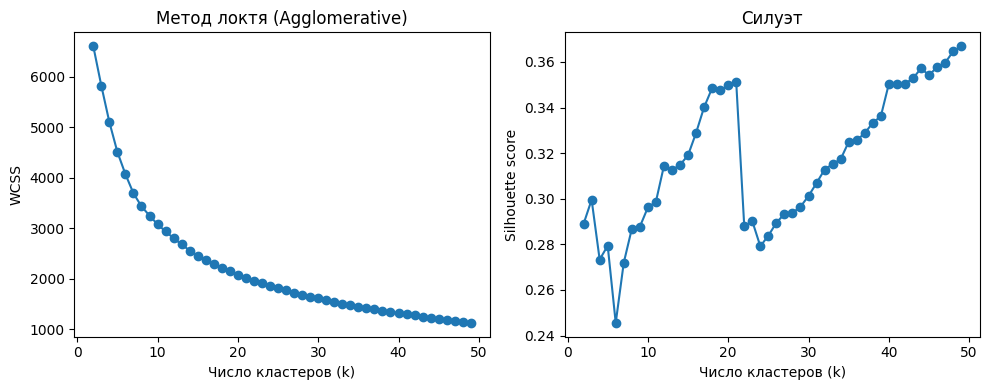

In [17]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(k_range, wcss_list, marker="o")
plt.xlabel("Число кластеров (k)")
plt.ylabel("WCSS")
plt.title("Метод локтя (Agglomerative)")

plt.subplot(1,2,2)
plt.plot(k_range, silhouette_list, marker="o")
plt.xlabel("Число кластеров (k)")
plt.ylabel("Silhouette score")
plt.title("Силуэт")

plt.tight_layout()
plt.show()

- Качество по метрике силуэт с 20 класреами +/- одинаков с 50 кластерам - лучше взять меньше класетров! Т.е. 20

In [18]:
best_k = 15
print(f"Оптимальное число кластеров: {best_k}")

Оптимальное число кластеров: 15


In [19]:
# делаем финальную кластеризацию с оптимальным числом кластеров
final_model = AgglomerativeClustering(n_clusters=best_k, linkage="ward")
final_labels = final_model.fit_predict(X)

In [20]:
data["cluster"] = final_labels

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

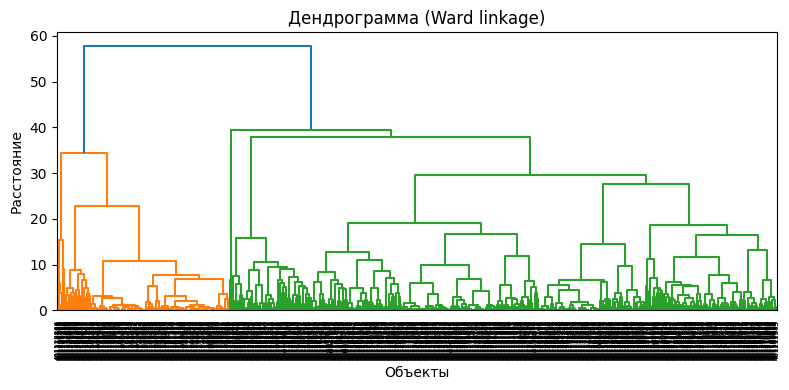

In [22]:
# ==== Дендрограмма ====
Z = linkage(X.toarray() if hasattr(X, "toarray") else X, method="ward")

plt.figure(figsize=(8, 4))
dendrogram(Z, labels=data["Номер Z-конфигурации"].astype(str).values, leaf_rotation=90)
plt.title("Дендрограмма (Ward linkage)")
plt.xlabel("Объекты")
plt.ylabel("Расстояние")
plt.tight_layout()
plt.show()

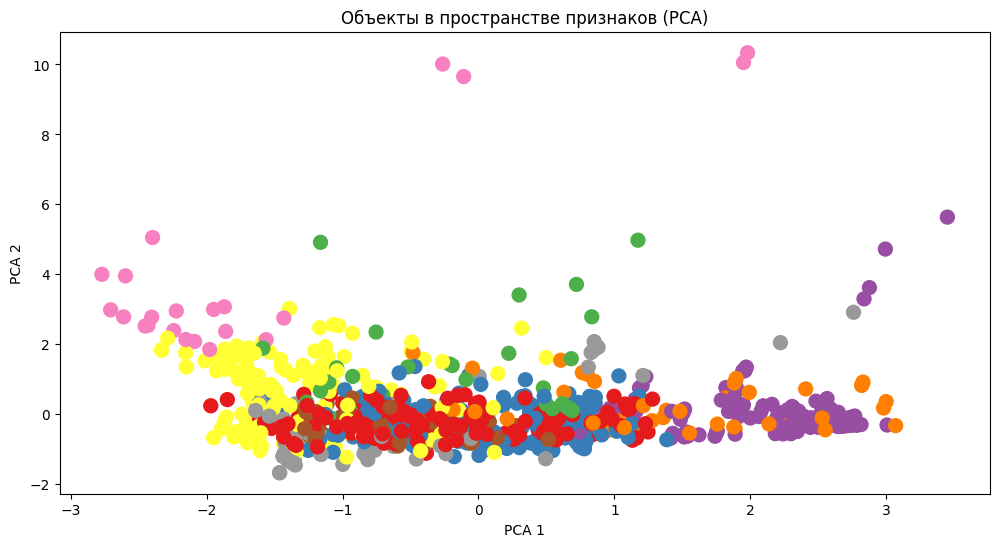

In [23]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray() if hasattr(X, "toarray") else X)

plt.figure(figsize=(12, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=final_labels, cmap="Set1", s=100)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Объекты в пространстве признаков (PCA)")
# plt.legend(final_labelstitle="Кластеры")
plt.show()

- Не подходит PCA

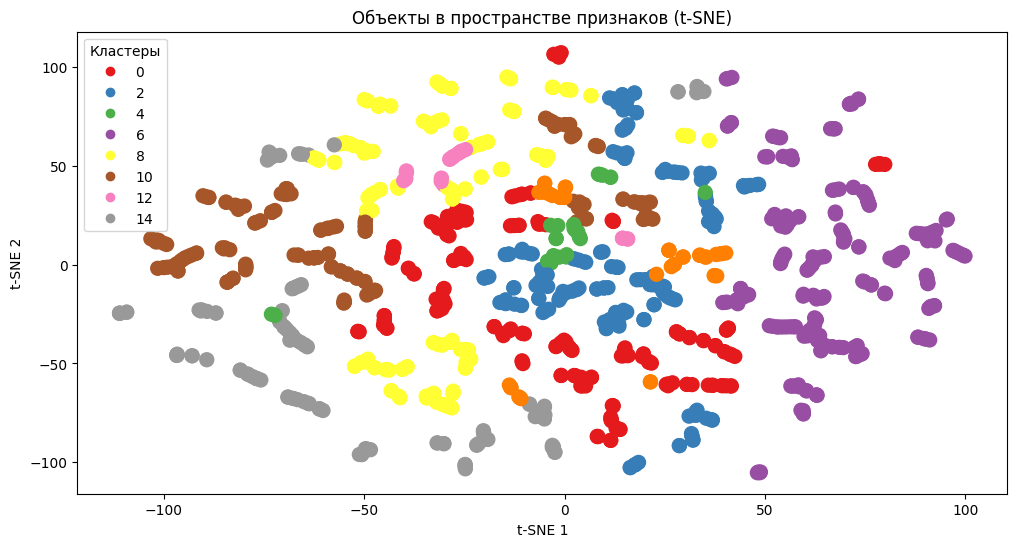

In [24]:
from sklearn.manifold import TSNE

# ==== t-SNE для визуализации ====
X_embedded = TSNE(n_components=2, random_state=42, perplexity=3).fit_transform(
    X.toarray() if hasattr(X, "toarray") else X
)

plt.figure(figsize=(12, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=final_labels, cmap="Set1", s=100)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Объекты в пространстве признаков (t-SNE)")
plt.legend(*scatter.legend_elements(), title="Кластеры")
plt.show()


In [ ]:
"""
Интерфейс Streamlit приложения

Фичи:
* Загрузка данных
* Буллет поинт -> есть дата или нет, если да, то выбираем диапазон, если нет берем все данные
* Выбор фичей -> 2-3 или все
* Выбор числа кластеров

Визуализация:
* Силуэт и метод локтя (библиотека plotly)
* Дендрограмма (библиотека plotly)
* Объекты в пространстве признаков (t-SNE) раскрасить по кластерам (библиотека plotly)
"""

In [25]:
data.describe(include='object')

,VID_TO,MARKA,ST_PROD
count,1162,1162,1162
unique,3,44,35
top,БЕЗ ТО,09Г2С,ГОСТ 19281-2014 ИЗМ 1
freq,873,295,269


In [26]:
data.describe(include='number')

,Номер Z-конфигурации,КлчПост/Потребн,target,TOL,SHIRINA,DLINA,cluster
count,1.162000e+03,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000
mean,4.011756e+08,51.318040,1181.951464,31.681145,2055.856282,8872.553356,6.336489
std,4.502185e+04,119.309281,51.417966,26.781364,518.731017,3689.762663,4.230181
min,4.008269e+08,1.042000,1056.212000,8.000000,1300.000000,3000.000000,0.000000
25%,4.011753e+08,14.502000,1160.000000,16.000000,1500.000000,6000.000000,2.000000
50%,4.011866e+08,25.704000,1174.700000,22.215000,2000.000000,6300.000000,6.000000
75%,4.012027e+08,53.649000,1197.600000,36.000000,2448.000000,12000.000000,10.000000
max,4.012151e+08,1911.060000,2010.000000,240.000000,4412.000000,15698.000000,14.000000


In [27]:
data.head()

,Номер Z-конфигурации,КлчПост/Потребн,target,TOL,SHIRINA,DLINA,VID_TO,MARKA,ST_PROD,cluster
0,401077983,53.526,1197.6,58.0,2440,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е),6
1,401090004,55.476,1197.6,32.2,2260,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е),6
2,401090006,47.301,1197.6,33.0,1880,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е),6
3,401090005,46.477,1197.6,38.0,1609,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е),6
4,401089979,143.408,1197.6,58.0,2450,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е),6


In [28]:
scaler = StandardScaler()

In [29]:
data_scaled = scaler.fit_transform(data[num_col[1:]])

Здесь `[1:]` для того чтобы признак `Номер Z-конфигурации` остался без изменений

In [30]:
df_scaled = pd.concat([pd.DataFrame(data_scaled, columns = num_col[1:]), data['Номер Z-конфигурации']], axis=1)

In [31]:
df_scaled

,target,TOL,SHIRINA,DLINA,Номер Z-конфигурации
0,0.304471,0.983153,0.740864,1.818094,401077983
1,0.304471,0.019382,0.393714,1.818094,401090004
2,0.304471,0.049266,-0.339158,1.818094,401090006
3,0.304471,0.236044,-0.861812,1.818094,401090005
4,0.304471,0.983153,0.760150,1.820805,401089979
...,...,...,...,...,...
1157,-0.660588,-0.473710,4.405226,0.847966,401207933
1158,4.886554,-0.847265,-0.088439,-0.223025,401214809
1159,4.886554,-0.809909,-0.088439,-0.223025,401214765
1160,4.886554,-0.735199,-0.088439,-0.223025,401213159


Закодируем категориальные признаки.

In [32]:
encoders = {cat:LabelEncoder().fit(data[cat]) for cat in cat_col}

In [33]:
encoded_data_cat_col = data[cat_col].apply(lambda cat: encoders[cat.name].transform(cat))

Соединим в один датафрейм

In [34]:
transform_data = pd.concat([df_scaled, encoded_data_cat_col],axis=1)

In [35]:
transform_data

,target,TOL,SHIRINA,DLINA,Номер Z-конфигурации,VID_TO,MARKA,ST_PROD
0,0.304471,0.983153,0.740864,1.818094,401077983,0,27,3
1,0.304471,0.019382,0.393714,1.818094,401090004,0,27,3
2,0.304471,0.049266,-0.339158,1.818094,401090006,0,27,3
3,0.304471,0.236044,-0.861812,1.818094,401090005,0,27,3
4,0.304471,0.983153,0.760150,1.820805,401089979,0,27,3
...,...,...,...,...,...,...,...,...
1157,-0.660588,-0.473710,4.405226,0.847966,401207933,0,30,22
1158,4.886554,-0.847265,-0.088439,-0.223025,401214809,1,35,24
1159,4.886554,-0.809909,-0.088439,-0.223025,401214765,1,35,24
1160,4.886554,-0.735199,-0.088439,-0.223025,401213159,1,35,24


In [36]:
transform_data.isna().sum()

target                  0
TOL                     0
SHIRINA                 0
DLINA                   0
Номер Z-конфигурации    0
VID_TO                  0
MARKA                   0
ST_PROD                 0
dtype: int64

**Номер Z-конфигурации явлется своего рода `id`. Поставим его в индекс датафрейма.**

In [37]:
Z_transform_data = transform_data.set_index('Номер Z-конфигурации')

In [38]:
Z_transform_data

,target,TOL,SHIRINA,DLINA,VID_TO,MARKA,ST_PROD
Номер Z-конфигурации,,,,,,,
401077983,0.304471,0.983153,0.740864,1.818094,0,27,3
401090004,0.304471,0.019382,0.393714,1.818094,0,27,3
401090006,0.304471,0.049266,-0.339158,1.818094,0,27,3
401090005,0.304471,0.236044,-0.861812,1.818094,0,27,3
401089979,0.304471,0.983153,0.760150,1.820805,0,27,3
...,...,...,...,...,...,...,...
401207933,-0.660588,-0.473710,4.405226,0.847966,0,30,22
401214809,4.886554,-0.847265,-0.088439,-0.223025,1,35,24
401214765,4.886554,-0.809909,-0.088439,-0.223025,1,35,24


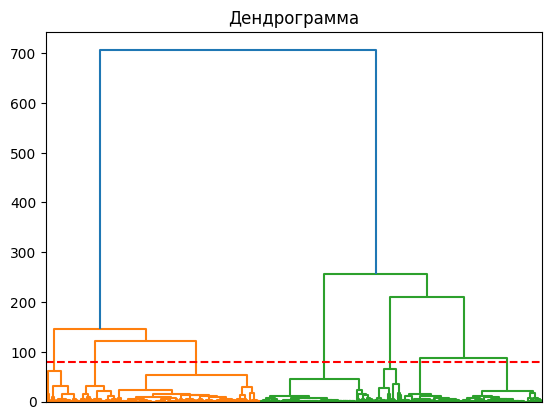

In [39]:
dendrogram = hc.dendrogram(hc.linkage(Z_transform_data, method = 'ward'), labels=Z_transform_data.index)
plt.title('Дендрограмма')
plt.xticks([])
plt.axhline(80, c='r', linestyle='--')
plt.show()

In [40]:
model = AgglomerativeClustering(n_clusters=7, linkage='ward')

In [41]:
X=Z_transform_data
y_hc = model.fit_predict(Z_transform_data)

In [42]:
columns = X.columns.to_list()


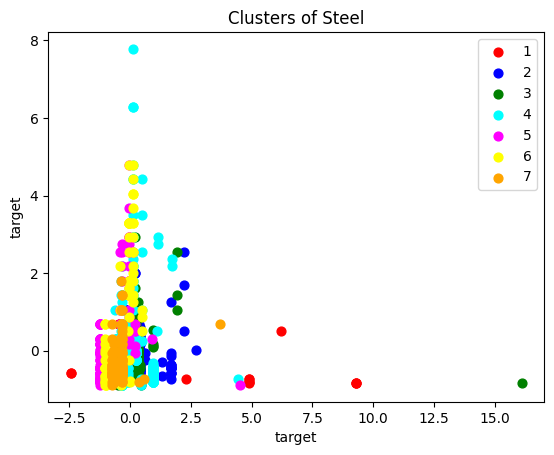

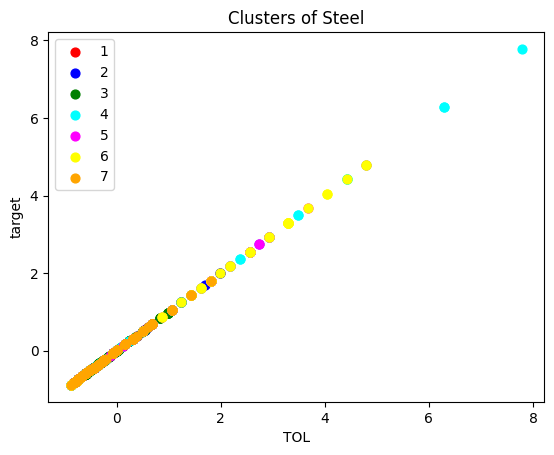

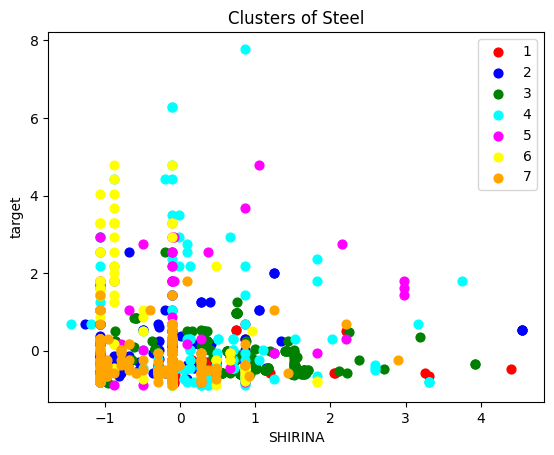

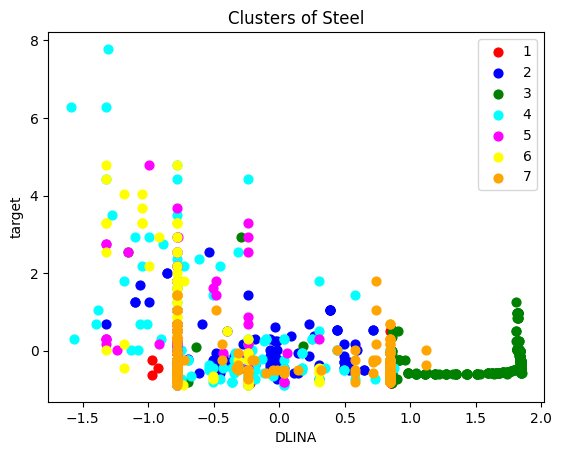

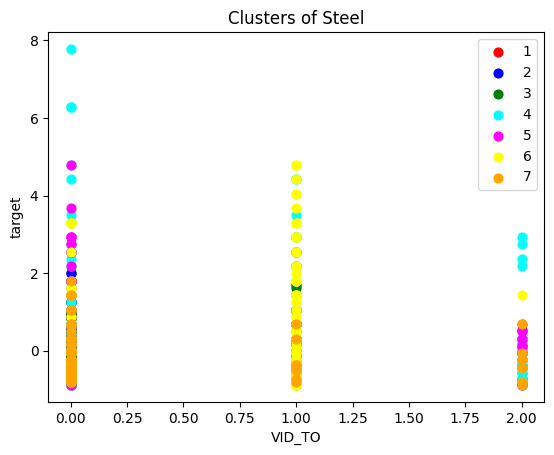

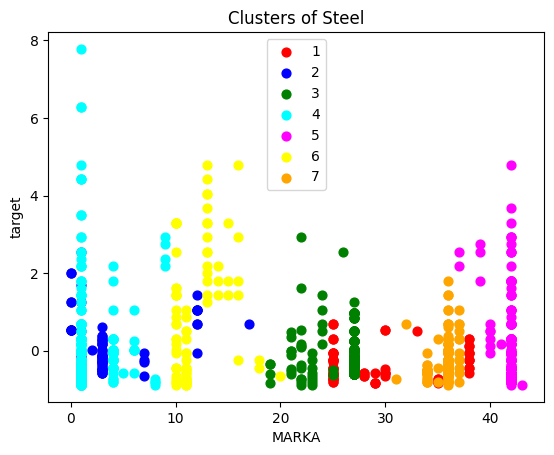

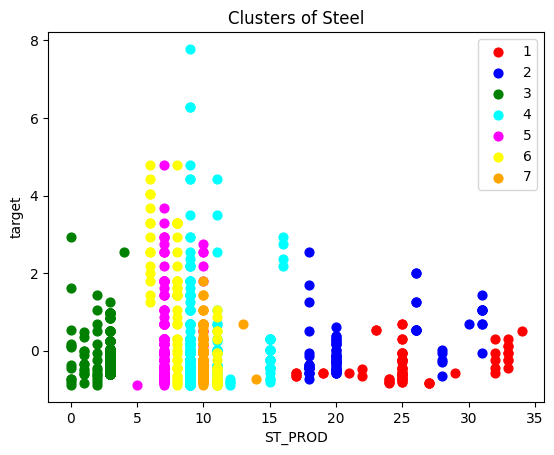

In [43]:
for i,col in enumerate(columns):
    plt.scatter(X.iloc[y_hc == 0, i], X.iloc[y_hc == 0, 1], s = 40, c = 'red', label = '1')
    plt.scatter(X.iloc[y_hc == 1, i], X.iloc[y_hc == 1, 1], s = 40, c = 'blue', label = '2')
    plt.scatter(X.iloc[y_hc == 2, i], X.iloc[y_hc == 2, 1], s = 40, c = 'green', label = '3')
    plt.scatter(X.iloc[y_hc == 3, i], X.iloc[y_hc == 3, 1], s = 40, c = 'cyan', label = '4')
    plt.scatter(X.iloc[y_hc == 4, i], X.iloc[y_hc == 4, 1], s = 40, c = 'magenta', label = '5')
    plt.scatter(X.iloc[y_hc == 5, i], X.iloc[y_hc == 5, 1], s = 40, c = 'yellow', label = '6')
    plt.scatter(X.iloc[y_hc == 6, i], X.iloc[y_hc == 6, 1], s = 40, c = 'orange', label = '7')
    
    plt.title('Clusters of Steel')
    plt.xlabel(col)
    plt.ylabel('target')
    plt.legend()
    plt.show()